<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/crop_yield_catboost(GridSearch_optimization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/crop_production_dataset.csv')
data = data.drop(columns=["Production"])
data.columns = data.columns.str.strip()
missing_values = data.isnull().sum()

# Print missing values for each column
print(missing_values)

State        0
District     0
Crop         9
Crop_Year    0
Season       0
Area         0
Yield        0
dtype: int64


In [ ]:
# Handle missing values
data["Crop"].fillna("Unknown", inplace=True)  # Filling categorical NaN
data = data.dropna(subset=["Production"])  # Removing rows where Production is NaN

<ipython-input-3-f47f82c59741>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Crop"].fillna("Unknown", inplace=True)  # Filling categorical NaN


In [ ]:
data = data.dropna()

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

State         0
District      0
Crop          0
Crop_Year     0
Season        0
Area          0
Production    0
Yield         0
dtype: int64


In [ ]:
data.head(5)

,State,District,Crop,Crop_Year,Season,Area,Yield
0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,1.40
1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,1.40
2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,0.74
3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,0.64
4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,0.75


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

In [ ]:
df = data  # Replace with actual file name

# Drop the index column if it exists
if "index" in df.columns:
    df.drop(columns=["index"], inplace=True)

# 📌 Step 2: Define categorical columns
categorical_features = ["State", "District", "Crop", "Season"]

# Convert categorical columns to categorical type
for col in categorical_features:
    df[col] = df[col].astype("category")

# 📌 Step 3: Define Features (X) and Target Variable (y)
X = df.drop(columns=["Yield"])
y = df["Yield"]

# 📌 Step 4: Split the dataset into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Step 5: Create a CatBoost Pool (Efficient Data Handling)
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [ ]:
model = CatBoostRegressor(
    iterations=1000,        # Number of boosting iterations
    learning_rate=0.1,     # Step size shrinkage
    depth=8,               # Tree depth
    verbose=100            # Print training progress
)

In [ ]:
model.fit(train_pool)

0:	learn: 829.2454596	total: 386ms	remaining: 6m 25s
100:	learn: 287.0258652	total: 19.7s	remaining: 2m 55s
200:	learn: 257.2490730	total: 38.9s	remaining: 2m 34s
300:	learn: 239.7611885	total: 1m	remaining: 2m 20s
400:	learn: 229.3750288	total: 1m 22s	remaining: 2m 3s
500:	learn: 218.8151256	total: 1m 42s	remaining: 1m 42s
600:	learn: 211.3416887	total: 2m 4s	remaining: 1m 22s
700:	learn: 202.9971648	total: 2m 25s	remaining: 1m 1s
800:	learn: 196.6158023	total: 2m 47s	remaining: 41.6s
900:	learn: 192.2512965	total: 3m 7s	remaining: 20.6s
999:	learn: 187.7255350	total: 3m 28s	remaining: 0us


In [ ]:
y_pred = model.predict(test_pool)

# 📌 Step 9: Evaluate the Model
# 📌 Step 9: Evaluate the Model
# Calculate RMSE without the 'squared' argument (for older scikit-learn versions)
mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
rmse = np.sqrt(mse)  # Calculate Root Mean Squared Error manually

r2 = r2_score(y_test, y_pred)

print(f"🔹 RMSE: {rmse}")
print(f"🔹 R² Score: {r2}")

🔹 RMSE: 316.7229310735883
🔹 R² Score: 0.8922437738823307


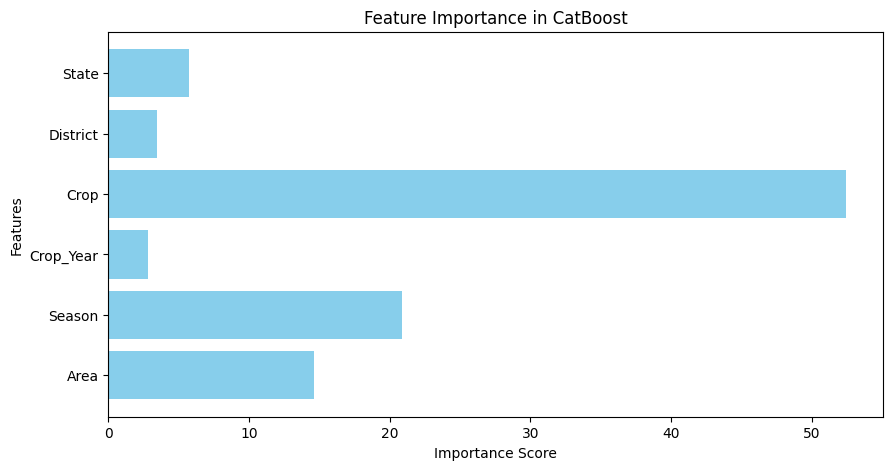

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost")
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature on top
plt.show()

In [ ]:
model.score(X_test,y_test)*100

96.84165096123205

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
catboost_model = CatBoostRegressor(
    verbose=0,  # Silent mode
    cat_features=categorical_features,
    task_type="GPU"  # Use GPU for faster training
)

# 📌 Define Parameter Grid
param_grid = {
    'iterations': [500,1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6,8,10],
    'l2_leaf_reg': [1, 3, 5],
}

# 📌 Perform Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,verbose = 3
)

In [ ]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x795d0ce8a090>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("🔹 Best Hyperparameters Found:")
print(grid_search.best_params_)

🔹 Best Hyperparameters Found:
{'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(train_pool)

In [ ]:
y_pred = best_model.predict(test_pool)

# 📌 Evaluate Performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"🔹 RMSE after GridSearch: {rmse}")
print(f"🔹 R² Score: {r2}")

🔹 RMSE after GridSearch: 3617219.6926280377
🔹 R² Score: 0.9682749009568278


In [ ]:
best_model.score(X_test,y_test)*100

96.82749009568278

,State,District,Crop,Crop_Year,Season,Area,Yield
0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,1.40
1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,1.40
2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,0.74
3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,0.64
4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,0.75


In [ ]:
df = data